In [2]:
import numpy as np
from tqdm import tqdm
from tqdm.notebook import tqdm
import os
import torch
from torch.utils.data import random_split
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [3]:
data_dir = 'S:/PFE/RSI-CB256'
classes = os.listdir(data_dir )
print(classes)

['airplane', 'airport_runway', 'artificial_grassland', 'avenue', 'bare_land', 'bridge', 'city_building', 'coastline', 'container', 'crossroads', 'dam', 'desert', 'dry_farm', 'forest', 'green_farmland', 'highway', 'hirst', 'lakeshore', 'mangrove', 'marina', 'mountain', 'parkinglot', 'pipeline', 'residents', 'river', 'river_protection_forest', 'sandbeach', 'sapling', 'sea', 'shrubwood', 'snow_mountain', 'sparse_forest', 'storage_room', 'stream', 'town']


In [4]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
desired_size = (64, 64)
transform = transforms.Compose([
    transforms.Resize(desired_size),
    transforms.ToTensor()
])

dataset = ImageFolder(data_dir, transform=transform)

In [5]:
img, label = dataset[0]
print(img.shape, label)

torch.Size([3, 64, 64]) 0


In [6]:
random_seed = 30
torch.manual_seed(random_seed)
val_size = 700
test_size = 900
train_size = len(dataset) - val_size - test_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)


(2530, 700, 900)

In [7]:
from torch.utils.data.dataloader import DataLoader
batch_size=128
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

In [8]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

images.shape: torch.Size([128, 3, 64, 64])


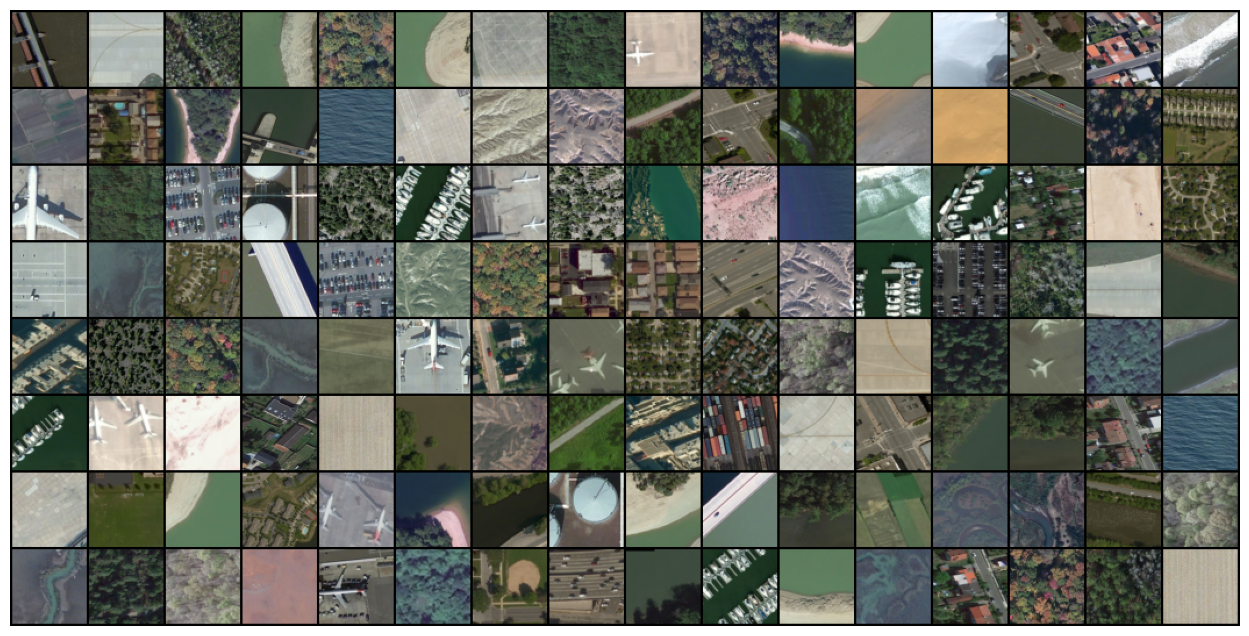

In [9]:
import torch.nn as nn
import torch.nn.functional as F
for images, _ in train_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [10]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [11]:
import torch.nn.functional as F
def criterion(outputs, labels):
    return F.cross_entropy(outputs, labels)
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds))


class MulticlassClassifierBase(nn.Module):
    
    def training_step(self, batch):
        img, label = batch
        out = self(img)
        loss = criterion(out, label)
        accu = accuracy(out, label)
        return accu ,loss
    def validation_step(self, batch):
        img, label = batch
        out = self(img)
        loss = criterion(out, label)
        accu = accuracy(out, label)
        return {"val_loss": loss.detach(), "val_acc": accu}
    
    def validation_epoch_ends(self, outputs):
        batch_loss = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {"val_loss":epoch_loss.item(), "val_acc":epoch_acc.item()}
    def epoch_end(self, epoch, result):
        print("Epoch [{}],train_accu: {:.4f}, learning_rate: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch,result['train_accu'], result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [13]:
import torchvision.models as models
class LULC_Model(MulticlassClassifierBase):
    def __init__(self):
        super().__init__()
        self.network = models.wide_resnet50_2(pretrained=True)
        n_inputs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
                              nn.Linear(n_inputs, 256),
                              nn.ReLU(),
                              nn.Dropout(0.5),
                              nn.Linear(256, 35),
                              nn.LogSoftmax(dim=1)
                                )
    def forward(self, xb):
        return self.network(xb)
    
    def freeze(self):
        for param in self.network.parameters():
            param.require_grad=False
        for param in self.network.fc.parameters():
            param.require_grad=True
    def unfreeze(self):
        for param in self.network.parameters():
            param.require_grad=True

In [14]:
modelpret = LULC_Model()

c:\Users\win 10\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\win 10\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
for images, labels in train_dl:
    print('images.shape:', images.shape)    
    out = modelpret(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 64, 64])
out.shape: torch.Size([128, 35])
out[0]: tensor([-3.5364, -3.6133, -3.3123, -3.6051, -3.6511, -3.7176, -3.4160, -3.4603,
        -3.3500, -3.6776, -3.7365, -3.4238, -3.4687, -3.5732, -3.5806, -3.7534,
        -3.5205, -3.4766, -3.3948, -3.5966, -3.8764, -3.5921, -3.2752, -3.6628,
        -3.4752, -3.6667, -3.7820, -3.3554, -3.6302, -3.5756, -3.9066, -3.5806,
        -3.4393, -3.7260, -3.4287], grad_fn=<SelectBackward0>)


In [16]:
def get_default_device():
    """Pick GPU if available, else CPU
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:"""
    return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [17]:
device = get_default_device()
device

device(type='cpu')

In [18]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(modelpret, device);
#DeviceDataLoader.__len__(train_dl)

## Training and Evaluation

In [19]:
@torch.no_grad()
def evaluate(model, valid_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in valid_loader]
    return model.validation_epoch_ends(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fit(epochs, max_lr,  model, train_loader, valid_loader, weight_decay=0,\
                grad_clip=None,opt_func=torch.optim.SGD, max_epochs_stop=3):
  
    history = []
    valid_loss_min = np.Inf
    valid_acc_max = 0
    model_file_name = 'S:/PFE/ClassifRepo/1-6/Results/lulc.pth'
    model_file_name2 = 'S:/PFE/ClassifRepo/1-6/Results/lulc_max_acc.pth'
    epochs_no_improve =  0
    optimizer = opt_func(model.parameters(), lr=max_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.00001)
                         
    for epoch in range(epochs):
        model.train()
        train_loss = []
        train_accu = []
        lrs = []
        for batch in tqdm(train_loader):
            
            accu, loss = model.training_step(batch)
            train_loss.append(loss)
            train_accu.append(accu)
            loss.backward()
            ## Gradient Clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            
            
            
        result = evaluate(model, valid_loader)
        scheduler.step(result['val_loss'])
        ########### Early Stopping ##############                                         
        valid_loss = result['val_loss']
        valid_acc = result['val_acc']
        if valid_acc > valid_acc_max:
            torch.save(model.state_dict(), model_file_name2)
            valid_acc_max = valid_acc
        if valid_loss<valid_loss_min:
            torch.save(model.state_dict(), model_file_name)
            valid_loss_min = valid_loss                                  
            epochs_no_improve = 0          
        else:
            epochs_no_improve += 1
            if epochs_no_improve > max_epochs_stop:
                result["train_loss"] = torch.stack(train_loss).mean().item()
                result["train_accu"] = torch.stack(train_accu).mean().item()
                result["lrs"] = lrs
                model.epoch_end(epoch, result)
                history.append(result)
                print("Early Stopping............................")
                return history                                
                                                 
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["train_accu"] = torch.stack(train_accu).mean().item()
        result["lrs"] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    print("VAL LOSS MIN {}".format(valid_loss_min))
    print("VAL ACC MAX {}".format(valid_acc_max))
    return history

In [29]:
'''@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history'''

In [20]:
model = to_device(LULC_Model(), device)

In [ ]:
torch.cuda.empty_cache()

In [21]:
## Hyper Parameters
max_epochs_stop = 10
max_lr = 1e-4
grad_clip = 0.1
weight_decay = 1e-3
batch_size = 64
criterion = nn.CrossEntropyLoss()
epochs = 10
opt_func = torch.optim.Adam
## Evaluating with non-trained model
evaluate(model, val_dl)

{'val_loss': 3.5734803676605225, 'val_acc': 0.06153036281466484}

In [22]:
## Freezing except last layer
model.freeze()
## Training
history = fit(epochs, max_lr, model, train_dl, val_dl, weight_decay, grad_clip, opt_func, max_epochs_stop)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [0],train_accu: 0.2547, learning_rate: 0.0001, train_loss: 3.2031, val_loss: 2.8362, val_acc: 0.4433


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1],train_accu: 0.6876, learning_rate: 0.0001, train_loss: 1.8541, val_loss: 1.1127, val_acc: 0.8057


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2],train_accu: 0.8862, learning_rate: 0.0001, train_loss: 0.7456, val_loss: 0.3988, val_acc: 0.9341


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3],train_accu: 0.9803, learning_rate: 0.0001, train_loss: 0.2107, val_loss: 0.1777, val_acc: 0.9698


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4],train_accu: 0.9968, learning_rate: 0.0001, train_loss: 0.0663, val_loss: 0.1184, val_acc: 0.9747


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5],train_accu: 0.9988, learning_rate: 0.0001, train_loss: 0.0405, val_loss: 0.0952, val_acc: 0.9773


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [6],train_accu: 0.9996, learning_rate: 0.0001, train_loss: 0.0252, val_loss: 0.0920, val_acc: 0.9812


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [7],train_accu: 0.9979, learning_rate: 0.0001, train_loss: 0.0288, val_loss: 0.0996, val_acc: 0.9716


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [8],train_accu: 0.9965, learning_rate: 0.0001, train_loss: 0.0358, val_loss: 0.1026, val_acc: 0.9721


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [9],train_accu: 0.9910, learning_rate: 0.0001, train_loss: 0.0512, val_loss: 0.1087, val_acc: 0.9721
VAL LOSS MIN 0.09196130186319351
VAL ACC MAX 0.9811890721321106


In [ ]:
'''num_epochs = 100
opt_func = torch.optim.Adam
lr = 0.001
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)'''

### Training Reports

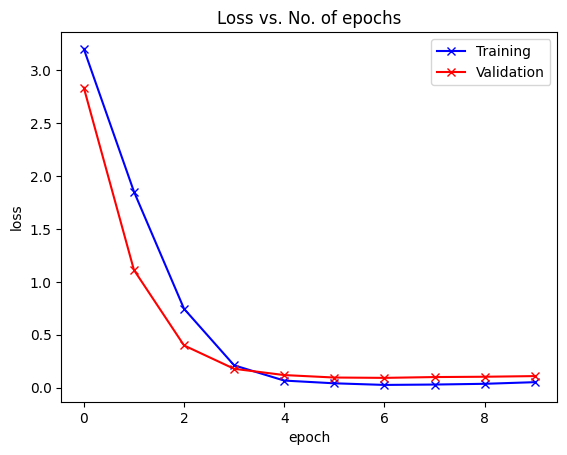

In [23]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
plot_losses(history)

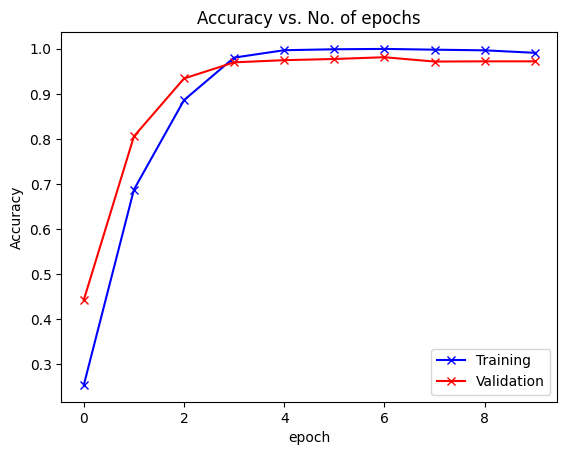

In [24]:
def plot_accuracy(history):
        
    train_accu = [x.get('train_accu') for x in history]
    val_accu = [x['val_acc'] for x in history]
    plt.plot(train_accu, '-bx')
    plt.plot(val_accu, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');
plot_accuracy(history)

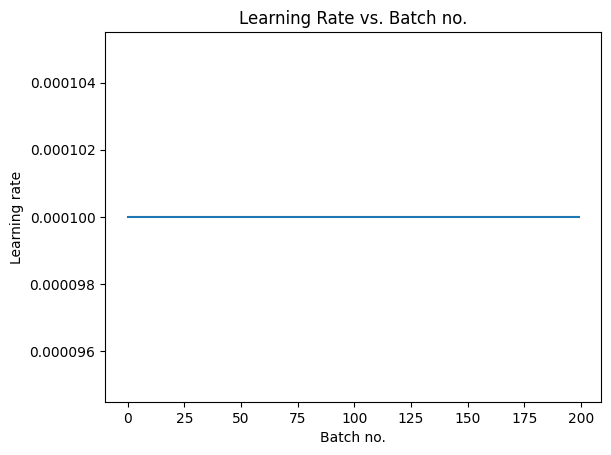

In [25]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
    
plot_lrs(history)

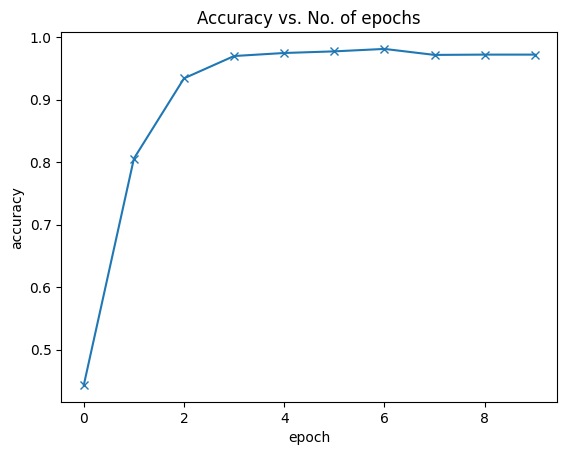

In [26]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
plot_accuracies(history)

In [ ]:
'''def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(history)'''

### Prediction Reports

In [28]:
test_dataset = test_ds

In [29]:
IDX_CLASS_LABELS = {
            0: 'airplane',
            1: 'airport_runway', 
            2: 'artificial_grassland',
            3: 'avenue',
            4: 'bare_land',
            5: 'bridge',
            6: 'city_building',
            7: 'coastline',
            8: 'container',
            9: 'crossroads',
            10: 'dam',
            11: 'desert',
            12:'dry_farm',
            13: 'forest',
            14: 'green_farmland',
            15: 'highway',
            16: 'hirst',
            17: 'lakeshore',
            18:'mangrove',
            19:'marina',
            20:'mountain',
            21: 'parkinglot',
            22: 'pipeline',
            23: 'residents',
            24: 'river',
            25: 'river_protection_forest',
            26: 'sandbeach',
            27: 'sapling',
            28: 'sea',
            29: 'shrubwood',
            30: 'snow_mountain',
            31: 'sparse_forest',
            32: 'storage_room',
            33: 'stream',
            34: 'town'
        }
CLASSES = ['airplane','airport_runway','artificial_grassland','avenue','bare_land','bridge','city_building','coastline','container','crossroads','dam','desert','dry_farm','forest','green_farmland','highway','hirst','lakeshore','mangrove','marina','mountain','parkinglot','pipeline','residents','river','river_protection_forest','sandbeach','sapling','sea','shrubwood','snow_mountain','sparse_forest','storage_room','stream', 'town']
CLASS_IDX_LABELS = dict()
for key, val in IDX_CLASS_LABELS.items():
          CLASS_IDX_LABELS[val] = key
NUM_CLASSES = len(IDX_CLASS_LABELS.items())
torch.manual_seed(10)

In [30]:
def encode_label(label):
    idx = CLASS_IDX_LABELS[label] 
    return idx
def decode_target(target, text_labels=True):
    result = []
    if text_labels:
        return IDX_CLASS_LABELS[target]
    else:
        return target
def show_sample(img, target=None):
    if target:
        print("Label" ,decode_target(int(target), text_labels=True))
    plt.imshow(img.permute(1, 2, 0))

### Predict Single Images
def predict_single(image):
    show_sample(image)
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    _, prediction = torch.max(preds.cpu().detach(), dim=1)
    return decode_target(int(prediction), text_labels=True)

In [31]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

'crossroads'

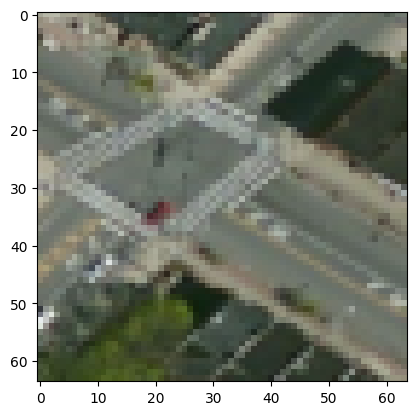

In [32]:
img, label = test_dataset[200]
predict_single(img)

Label: crossroads , Predicted: crossroads


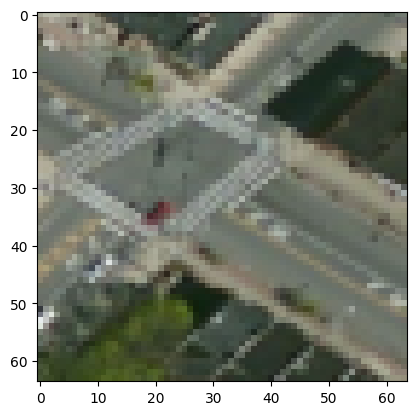

In [33]:
img, label = test_dataset[200]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

## Evaluation on whole dataset

In [66]:
batch_size =1
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_pred, labels = [], []
    model = model.to(device)  # Move the model to the GPU if available
    for xb, label in tqdm(dl):
        xb = xb.to(device)  # Move the input data to the GPU if available
        probs = model(xb)
        _, pred = torch.max(probs.cpu().detach(), dim=1)
        batch_pred.extend(pred.cpu().detach().tolist())  # Extend the list with predictions
        labels.extend(label.tolist())  # Extend the list with labels
    return batch_pred, labels

In [72]:

## Accuracy Evaluation
import torch

def final_accuracy(predictions, labels):
    predictions = torch.tensor(predictions, device=device)  # Convert to a tensor and move to the same device as 'device'
    labels = torch.tensor(labels, device=device)  # Convert to a tensor and move to the same device as 'device'
    
    correct = (predictions == labels).sum().item()  # Count the number of correct predictions
    total = len(predictions)  # Total number of predictions

    accuracy = correct / total  # Calculate accuracy
    print("Accuracy:", accuracy)

In [73]:
dataset = dataset = ImageFolder(data_dir, transform=transform)
full_dl=DataLoader(dataset, batch_size*2, shuffle=True, num_workers=2, pin_memory=True)
device =get_default_device()
full_dl = DeviceDataLoader(full_dl, device)

In [75]:
from sklearn.metrics import confusion_matrix
batch_size = 1
predictions, labels = predict_dl(full_dl, model)
final_accuracy(predictions, labels)
preds = [x for x in predictions]
labs = [x for x in labels]
cm = confusion_matrix(preds, labs)
print(cm)

  0%|          | 0/2065 [00:00<?, ?it/s]

In [ ]:
## Plotting Confusion matrix
import seaborn as sns
import pandas as pd
df_cm = pd.DataFrame(cm, CLASSES, CLASSES)
sns.set(font_scale=1.4) # for label size
plt.figure(figsize = (16,6))
sns.heatmap(df_cm, annot=True)

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 1.1884303092956543, 'val_acc': 0.7931759357452393}

In [ ]:
torch.save(model.state_dict(), 'satellite-classification-model.pth')

In [ ]:
## Accuracy Evaluation
def final_accuracy(predictions, labels):
  predictions = to_device(predictions, device)
  labels = to_device(labels, device)
  ## Total Accuracy
  total = 0
  for i in range(len(predictions)):
    if predictions[i] == labels[i]:
      total += 1
  acc = total/len(predictions)
  print(acc)

In [ ]:
from tqdm import tqdm
from tqdm.notebook import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix

batch_size =1
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_pred, labels = [], []
    for xb, label in tqdm(dl):
        xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
        yb = model(xb)
    # Pick index with highest probability
        _, preds  = torch.max(yb, dim=1)
        batch_pred.append(preds.cpu().detach())     
        labels.append(label)   
    return [x for x in batch_pred], \
            [x for x in labels]

In [ ]:
predictions, labels = predict_dl(full_dl, model)
final_accuracy(predictions, labels)
preds = [x.item() for x in predictions]
labs = [x.item() for x in labels]
cm = confusion_matrix(preds, labs)
cm

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [ ]:
torch.save(model.state_dict(), 'satellite-classification-model.pth')